In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

Created a function, which is used for loading the images

In [2]:
def load_images(path, type):

    file_list = os.listdir(path)
    images = []

    for filename in file_list:
        if filename.endswith(type): 
            input_image_path = os.path.join(path, filename)
            input_image = cv2.imread(input_image_path)
            gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
            images.append(gray_image)
    
    return images

In [3]:
images_path = 'image_labels'

images = load_images(images_path, '.png')

In [4]:
image_11_path = 'image_labels/048_43-11-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_02-Fish Eye Corrected.png'
image_14_path = 'image_labels/048_43-14-ROOT1-2023-08-08_pvd_OD0001_col-0_01-Fish Eye Corrected.png'
image_18_path = 'image_labels/048_43-18-ROOT1-2023-08-08_pvd_OD0001_col-0_02-Fish Eye Corrected.png'

In [5]:
image_11 = cv2.imread(image_11_path)
image_14 = cv2.imread(image_14_path)
image_18 = cv2.imread(image_18_path)

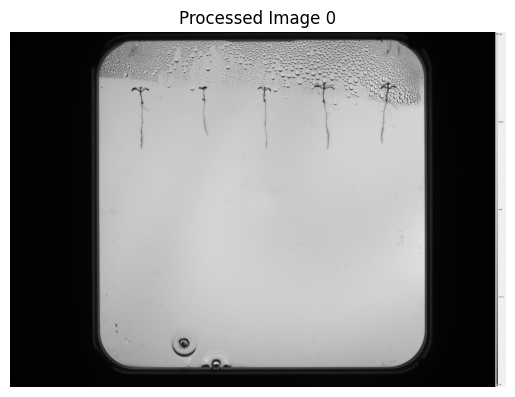

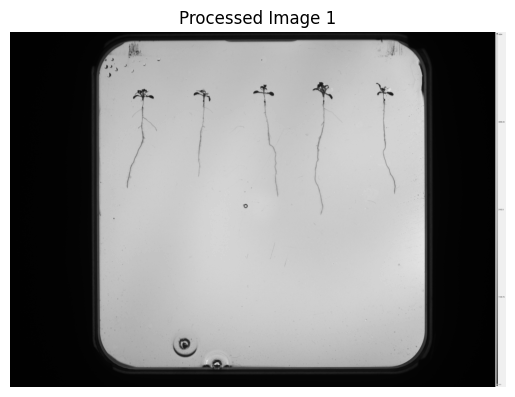

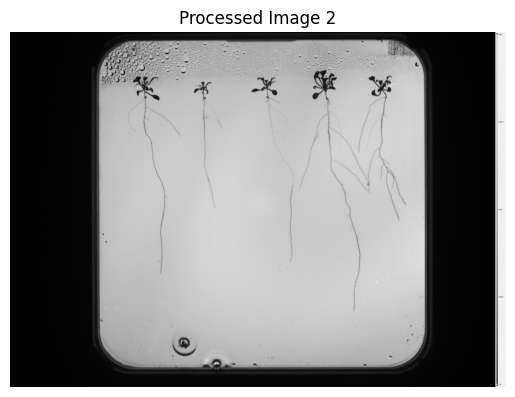

In [6]:
for idx, img in enumerate(images):
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Processed Image {idx}")
    plt.axis('off')  
    plt.show()

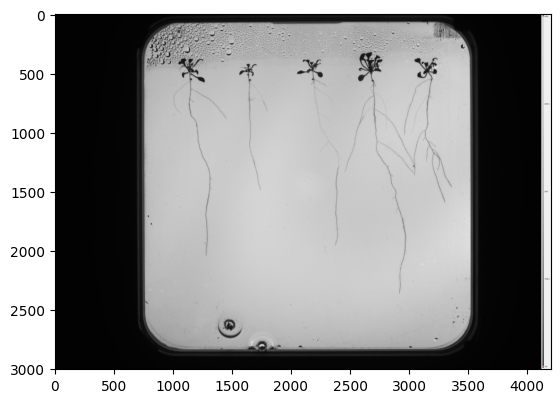

In [7]:
plt.imshow(image_18, cmap="gray")

The image is getting converted to grey scale, so it can be used for the filtering. In the same cell, I dilate the image along with eroding it (closing it), so I can reduce the noise. I decided to do that, so I can take the area of the petri dish easier.

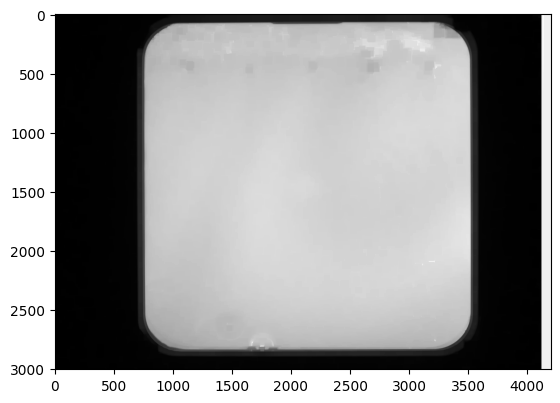

In [8]:
im_gray = cv2.cvtColor(image_18, cv2.COLOR_BGR2GRAY)

kernel = np.ones((50, 50), dtype="uint8")

im_e = cv2.dilate(im_gray, kernel, iterations=1)
im_closing = cv2.erode(im_e, kernel, iterations=1)

plt.imshow(im_closing, cmap="gray")

Afterwards, I perform tresholding to create a binary mask of the image. This way I am simplifying the image for further processes and take it as my area of interest.

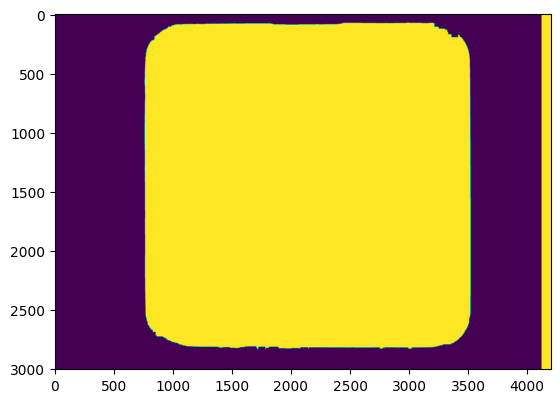

In [9]:
th, output_im = cv2.threshold(im_closing, 160, 255, cv2.THRESH_BINARY)
plt.imshow(output_im)

I use the connectedComponentsWithStats function, so I can take the stats of the petri dish, so this way I can use the metrics.

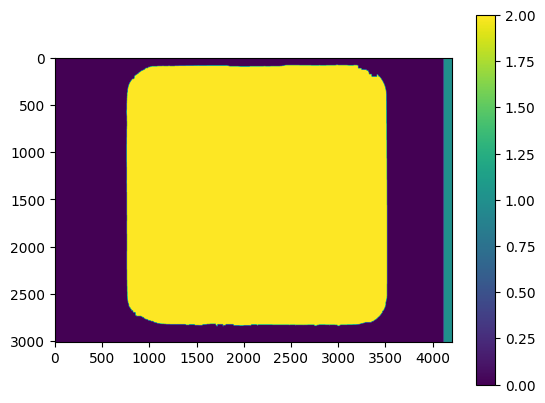

In [10]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)
plt.imshow(labels)
plt.colorbar()

Next I create a loop, which iterates through the stats variable and it takes the object with the biggest area as we suppose that it should be the petri dish. Then, we store the coordinates.

In [11]:
area_of_interest = None
largest_area = 0

for i in range(1, len(stats)):
    x, y, w, h, area = stats[i]
    if area > largest_area:
        largest_area = area
        area_of_interest = (x, y, w, h)

Lastly, the collected coordinates were used to crop the image

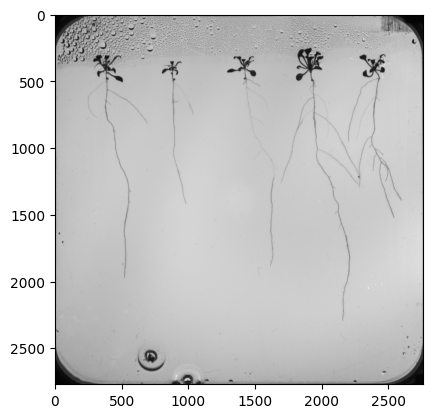

In [12]:
x, y, w, h = area_of_interest

roi = image_18[y:y+h, x:x+w]
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

In [13]:
test_path = 'task2_test_images'

test_images = load_images(test_path, type='.png')

Here I put everything all together as I add 2 new things to the code:
- It checks whether an image is grey scale and if not, converts it;
- Secondly, I noticed that it does not crop in a perfect square and there is always a difference of 10 between width and height, so I made the cropped images a square.

In [14]:
def roi_image(input_im, offset=10):

    if len(input_im.shape) == 3 and input_im.shape[2] == 3:
        im_gray = cv2.cvtColor(input_im, cv2.COLOR_BGR2GRAY)
    elif len(input_im.shape) == 2:
        # If the input image is already grayscale, no need to convert
        im_gray = input_im
    else:
        # Handle other cases (e.g., images with more than 3 channels)
        raise ValueError("Unsupported number of channels in input image")

    kernel = np.ones((50, 50), dtype="uint8")

    im_e = cv2.dilate(im_gray, kernel, iterations=1)
    im_closing = cv2.erode(im_e, kernel, iterations=1)

    th, output_im = cv2.threshold(im_closing, 160, 255, cv2.THRESH_BINARY)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    area_of_interest = None
    largest_area = 0

    for i in range(1, len(stats)):
        x, y, w, h, area = stats[i]
        if area > largest_area:
            largest_area = area
            area_of_interest = (x, y, w, h)

    x, y, w, h = area_of_interest

    # Adjust width and height to make a perfect square with an offset
    side_length = max(w, h) + 2 * offset
    x = max(0, x - offset)
    y = max(0, y - offset)

    roi = input_im[y:y+side_length, x:x+side_length]
    return roi

Here I test 5 images and it works fine.

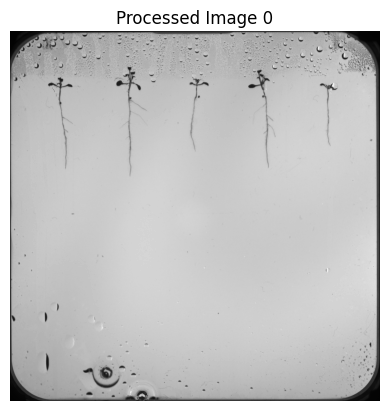

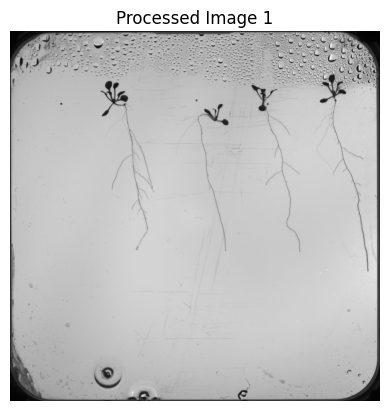

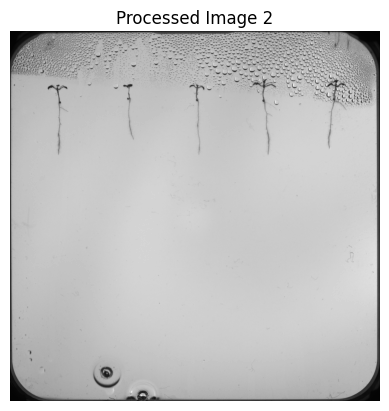

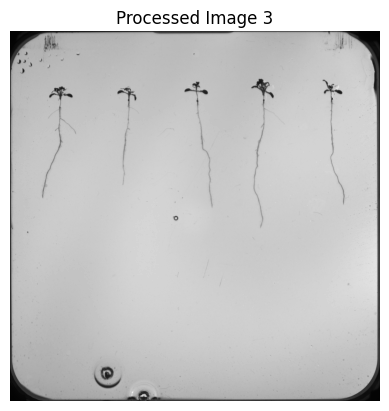

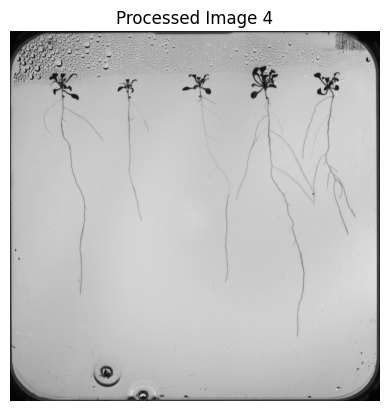

In [15]:
preprocessed_images = [roi_image(input_image) for input_image in test_images]

for idx, img in enumerate(preprocessed_images):
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(f"Processed Image {idx}")
    plt.axis('off')  
    plt.show()